# Text Mining Python
The student will apply basic Text Mining methods (mainly text pre-processing) to investigate and analyze the provided head and neck cancer medication textual corpus. It contains about 600 textual documents, each describing the medication prescribed to a different patient suffering a head/neck cancer in a given stage. 

## Requirements
1. Add a further column to the CSV document indicating whether the cancer is in early or later stage, acording to the seer_stage field. We will consider that a cancer is in later stage if seer_state is 4, 5 or 7. It will be in early_stage otherwise. Filter out non-applicable (8) or unstaged, unknown and unspecified patients (9)

2. Build a word cloud for early stage, later stage and the complete archive (in the latter case, include also non-applicable and unstaged patients). Analyze and discuss the results.

3. Search the available literature and choose a state-of-the-art method for keyword extraction different from word clouds. Apply the chosen method to, again, early stage, later stage and the complete archive. Analyze and discuss the results. Compare with the previous approach.

4. Prepare a presentation (about 10 minutes) in PDF format describing the experiments (and the associated methods), the results, the discussion and the conclusions. This presentation will be held at class on  Feb 17th, 2020.

## Import packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from google.colab import drive
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk
#nltk.download()

In [0]:
!pip install git+https://github.com/boudinfl/pke.git
!python -m nltk.downloader stopwords
!python -m nltk.downloader universal_tagset
!python -m spacy download en # download the english model

In [0]:
import pke
import spacy
import re
from nltk.corpus import stopwords
from string import punctuation, digits

## Read data


In [0]:
drive.mount('/content/gdrive')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TextMiningPython/data/corpus.csv')
# stop_words = set(STOPWORDS)
stop_words = set(stopwords.words('english')) 
nlp = spacy.load('en_core_web_sm')
selected_pos = ['PROPN', 'NOUN', 'VERB', 'ADJ']

## Filter columns

In [0]:
dataset = dataset.drop(['PID', 'ENC_ID', 'TOTAL_DOSE_COUNT', 'MEDICATION_DESC', 'DOSE', 'UNIT', 'FREQUENCY'], axis=1)

## Create method to transform column

In [0]:
def normalize_seer_stage(seer_stage):
    if seer_stage in [4, 5, 7]:
        return 'later_stage'
    elif seer_stage in [8, 9]:
        return 'non-applicable'
    else:
        return 'early_stage'

## Add new column with normalization

In [0]:
dataset['Normalized_seer_stage'] = dataset.seer_stage.apply(lambda x: normalize_seer_stage(x))

## Show transformed dataset

In [0]:
print(dataset.head(5))

   seer_stage  ... Normalized_seer_stage
0           1  ...           early_stage
1           1  ...           early_stage
2           4  ...           later_stage
3           1  ...           early_stage
4           9  ...        non-applicable

[5 rows x 3 columns]


## Prepare variables that will be used

### Method to get and cleantokens

In [0]:
def get_tokens(summary):
  return [token for token in summary.split()]

def remove_pos_tags(document):
  cleaned_document_pos = nlp(document)

  selected_words = []
  for sent in cleaned_document_pos.sents:
    for token in sent:
      if token.pos_ in selected_pos and token.is_stop is False:
        selected_words.append(token.text)

  return " ".join(selected_words)

def clean_document(document):
  ## Remove punctuation
  cleaned_document = document.translate(str.maketrans('', '', punctuation))
  ## Remove rest of symbols
  cleaned_document = re.sub('[\n\r]', ' ', cleaned_document)
  ## Remove consecutive whitespaces
  cleaned_document = re.sub('\s+', " ", cleaned_document);
  ## Remove leading and trailing whitespaces.
  cleaned_document = cleaned_document.strip()
  ## Remove stopwords and pos tags
  cleaned_document = remove_pos_tags(cleaned_document)
  ## Lowercase
  cleaned_document = cleaned_document.lower()

  return cleaned_document

def clean_documents(documents):
  return [clean_document(document) for document in documents]

### Divide categories as explained

In [0]:
early_stage_dataset = dataset[dataset.Normalized_seer_stage == 'early_stage']
later_stage_dataset = dataset[dataset.Normalized_seer_stage == 'later_stage']

AttributeError: ignored

Clean each document

In [0]:
all_documents_cleaned = clean_documents(dataset.MEDICATION_SUMMARY)
early_stage_documents_cleaned = clean_documents(early_stage_dataset.MEDICATION_SUMMARY)
later_stage_documents_cleaned = clean_documents(later_stage_dataset.MEDICATION_SUMMARY)

In [0]:
dataset.MEDICATION_SUMMARY

0            (Zantac) 150 mg tablet oral two times a day
1              5,000 unit subcutaneous three times a day
2                         (Unasyn) 15 g IV every 6 hours
3      25 - 50 microgram IV every 5 minutes PRN sever...
4                   (Zocor) 40 mg tablet oral at bedtime
                             ...                        
657    1 - 4 mg IV every 10 minutes PRN severe pain\r...
658          (Zantac) 150 mg tablet oral two times a day
659    (Motrin) 600 mg tablet oral every 6 hours PRN ...
660    (Cleocin) 900 mg IV pre-procedure Give 30-60 m...
661    1 - 4 mg IV every 10 minutes PRN severe pain\r...
Name: MEDICATION_SUMMARY, Length: 662, dtype: object

In [0]:
all_documents_cleaned[:20]

['zantac mg tablet oral times day',
 'unit subcutaneous times day',
 'unasyn g iv hours',
 'microgram iv minutes prn severe pain maximum dose mcg pacu protocol',
 'zocor mg tablet oral bedtime',
 'mg ivpo hours administered iv po',
 'zantac mg tablet oral times day',
 'mg tablet oral hours calcium level drawn',
 'mg tablet oral hours prn pain',
 'magox mg tablet oral directed prn magnesium mag mg magnesium oxide',
 'lortab elixir ml solution oral hours prn pain g tube',
 'unit subcutaneous times day',
 'norco tablet oral takes scheduled dose q hours prn',
 'zofran mg iv hours prn refractory postop nauseavomiting',
 'artificial tears drop eye times day',
 'tylenol tablet oral hours prn pain',
 'mg oral',
 'tylenol mg tablet oral hours prn mild pain',
 'mg tablet oral times day meals',
 'microgram iv minutes prn severe pain maximum dose mcg pacu protocol']

### Join all words

In [0]:
all_words = ' '.join(all_documents_cleaned)
early_stage_words = ' '.join(early_stage_documents_cleaned)
later_stage_words = ' '.join(later_stage_documents_cleaned)

### Get tokens from each dataset

In [0]:
all_words_tokens = get_tokens(all_words)
early_stage_words_tokens = get_tokens(early_stage_words)
later_stage_words_tokens = get_tokens(later_stage_words)

## Worldcloud

### Method to generate and show worldclouds

### Join tokens for worldcloud

In [0]:
all_words_joined = ' '.join(all_words_tokens)
early_stage_words_joined = ' '.join(early_stage_words_tokens)
later_stage_words_joined = ' '.join(later_stage_words_tokens)

In [0]:
def generate_show_wordcloud(tokens):
  wordcloud = WordCloud(width = 1600, height = 1000, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(tokens)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

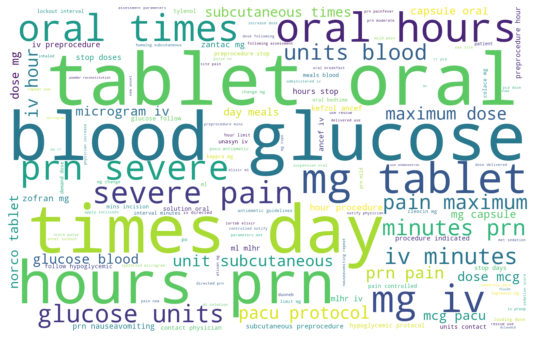

In [0]:
generate_show_wordcloud(all_words_joined)

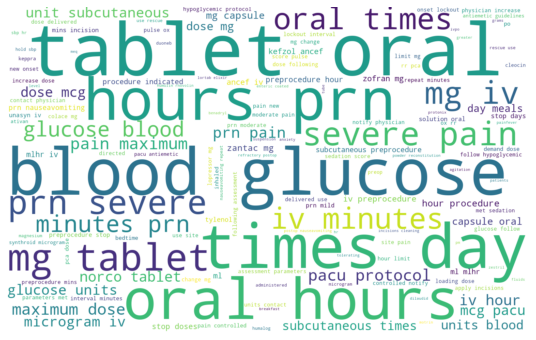

In [0]:
generate_show_wordcloud(early_stage_words_joined)

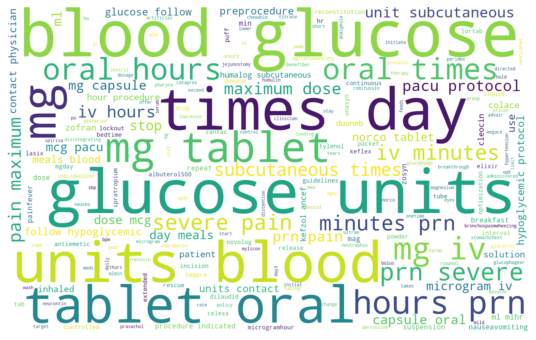

In [0]:
generate_show_wordcloud(later_stage_words_joined)

## Common data for all algorithms

In [0]:
pos = {'NOUN', 'PROPN', 'VERB', 'ADJ'}
separator = ". \n"

all_documents_cleaned_joined = separator.join(all_documents_cleaned)
early_stage_documents_cleaned_joined = separator.join(early_stage_documents_cleaned)
later_stage_documents_cleaned_joined = separator.join(later_stage_documents_cleaned)

## TextRank

In [0]:
def get_textrank_keyphrases(document, n):
  # define the set of valid Part-of-Speeches
  # 1. create a TextRank extractor.
  extractor =  pke.unsupervised.TextRank()

  # 2. load the content of the document.
  extractor.load_document(input=document,
                          language='en',
                          normalization=None)

  # 3. build the graph representation of the document and rank the words.
  #    Keyphrase candidates are composed from the 33-percent
  #    highest-ranked words.
  extractor.candidate_weighting(window=2,
                                pos=pos,
                                top_percent=0.33)

  # 4. get the 10-highest scored candidates as keyphrases
  keyphrases = extractor.get_n_best(n=n)
  return keyphrases

In [0]:
get_textrank_keyphrases(all_documents_cleaned_joined, 10)

[('dose mg repeat minutes hours demand dose mg', 0.17586587754882824),
 ('mg solution oral oral hours prn', 0.15279456086396861),
 ('mg tablet oral hours prn mild pain', 0.15253069646195594),
 ('mg tablet oral hours prn pain', 0.14948002456390955),
 ('mg solution oral hours prn pain', 0.14397925098588388),
 ('oral daily liquid mg doses mg', 0.1394137939321492),
 ('mg tablet oral times day prn', 0.1350123907852863),
 ('mg tablet oral hours prn', 0.13429310384815804),
 ('mg tablet oral hours stat dose pacu', 0.132362938033654),
 ('mg iv minutes prn pain stop times', 0.12969142379065657)]

In [0]:
get_textrank_keyphrases(early_stage_documents_cleaned_joined, 10)

[('dose mg repeat minutes hours demand dose mg', 0.17872469322471046),
 ('mg tablet oral hours prn mild pain', 0.16049568304063963),
 ('mg tablet oral hours prn pain', 0.15639593092281412),
 ('mg solution oral hours prn pain', 0.14962930357856624),
 ('protocol blood glucose units blood glucose units blood glucose units blood glucose units blood glucose units blood glucose units blood glucose units contact physician',
  0.14665899253443904),
 ('mg tablet oral hours prn', 0.14395252575596512),
 ('mg tablet oral hours stat dose pacu', 0.14268109992428563),
 ('mg tablet oral times day prn', 0.1402654149340213),
 ('mg solution oral oral hours', 0.1333659339795367),
 ('mg tablet oral directed prn magnesium', 0.12880460431876223)]

In [0]:
get_textrank_keyphrases(later_stage_documents_cleaned_joined, 10)

NameError: ignored

## MultipartiteRank

In [0]:
# 1. create a MultipartiteRank extractor.
extractor = pke.unsupervised.MultipartiteRank()

# 2. load the content of the document.
extractor.load_document(input=document)

# 3. select the longest sequences of nouns and adjectives, that do
#    not contain punctuation marks or stopwords as candidates.
stoplist = list(punctuation)
stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
stoplist += stopwords.words('english')
extractor.candidate_selection(pos=pos, stoplist=stoplist)

# 4. build the Multipartite graph and rank candidates using random walk,
#    alpha controls the weight adjustment mechanism, see TopicRank for
#    threshold/method parameters.
extractor.candidate_weighting(alpha=1.1,
                              threshold=0.74,
                              method='average')

# 5. get the 10-highest scored candidates as keyphrases
keyphrases = extractor.get_n_best(n=10)

AttributeError: ignored

In [0]:
keyphrases

## TopicRank

In [0]:
def get_topicrank_keyphrases(document, n):
  # 1. create a TopicRank extractor.
  extractor = pke.unsupervised.TopicRank()

  # 2. load the content of the document.
  extractor.load_document(input=document)

  # 3. select the longest sequences of nouns and adjectives, that do
  #    not contain punctuation marks or stopwords as candidates.
  stoplist = list(punctuation)
  stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
  stoplist += stopwords.words('english')
  extractor.candidate_selection(pos=pos, stoplist=stoplist)

  # 4. build topics by grouping candidates with HAC (average linkage,
  #    threshold of 1/4 of shared stems). Weight the topics using random
  #    walk, and select the first occuring candidate from each topic.
  extractor.candidate_weighting(threshold=0.75, method='average')

  # 5. get the 10-highest scored candidates as keyphrases
  keyphrases = extractor.get_n_best(n=n)
  return keyphrases

In [0]:
get_topicrank_keyphrases(all_documents_cleaned_joined, 10)

[('hours', 0.14946426901123536),
 ('tablet oral times day', 0.11736608596366781),
 ('norco', 0.06485167673252912),
 ('microgram iv minutes', 0.04810994293779719),
 ('tablet oral bedtime', 0.04291437504770351),
 ('mg iv minutes', 0.03952418918485051),
 ('zofran', 0.029899327877759698),
 ('mg oral', 0.029164895053582864),
 ('mg iv hours stop hours', 0.027325159305146823),
 ('zantac', 0.025146970099827186)]

## PositionRank



In [0]:
# define the grammar for selecting the keyphrase candidates
grammar = "NP: {<ADJ>*<NOUN|PROPN>+}"

# 1. create a PositionRank extractor.
extractor = pke.unsupervised.PositionRank()

# 2. load the content of the document.
extractor.load_document(input=document,
                        language='en',
                        normalization=None)

# 3. select the noun phrases up to 3 words as keyphrase candidates.
extractor.candidate_selection(grammar=grammar,
                              maximum_word_number=3)

# 4. weight the candidates using the sum of their word's scores that are
#    computed using random walk biaised with the position of the words
#    in the document. In the graph, nodes are words (nouns and
#    adjectives only) that are connected if they occur in a window of
#    10 words.
extractor.candidate_weighting(window=10,
                              pos=pos)

# 5. get the 10-highest scored candidates as keyphrases
keyphrases = extractor.get_n_best(n=10)
keyphrases

# Other approaches

## Yake

In [0]:
def get_yake_keyphrases(document, n):
  # 1. create a YAKE extractor.
  extractor = pke.unsupervised.YAKE()

  # 2. load the content of the document.
  extractor.load_document(input=document,
                          language='en',
                          normalization=None)


  # 3. select {1-3}-grams not containing punctuation marks and not
  #    beginning/ending with a stopword as candidates.
  stoplist = stopwords.words('english')
  extractor.candidate_selection(n=3, stoplist=stoplist)

  # 4. weight the candidates using YAKE weighting scheme, a window (in
  #    words) for computing left/right contexts can be specified.
  window = 2
  use_stems = False # use stems instead of words for weighting
  extractor.candidate_weighting(window=window,
                                stoplist=stoplist,
                                use_stems=use_stems)

  # 5. get the 10-highest scored candidates as keyphrases.
  #    redundant keyphrases are removed from the output using levenshtein
  #    distance and a threshold.
  threshold = 0.8
  keyphrases = extractor.get_n_best(n=n, threshold=threshold)
  return keyphrases

In [0]:
get_yake_keyphrases(all_documents_cleaned_joined, 10)

[('oral hours prn', 0.00044948673986994794),
 ('tablet oral hours', 0.0005056586567615587),
 ('tablet oral', 0.0005356403725636605),
 ('oral times day', 0.0005798127143833399),
 ('tablet oral times', 0.000736720866851178),
 ('hours prn pain', 0.0008118248283160083),
 ('blood glucose', 0.0008613307453342623),
 ('oral hours', 0.0008862171103907606),
 ('oral', 0.0009119997906591169),
 ('prn severe pain', 0.000979316375245752)]

## TF-IDF

In [0]:
x = 0
for doc in document.split("\n"):
  file = open("/content/gdrive/My Drive/documents/" + str(x) + ".txt","a") 
  file.write(doc)
  x = x + 1
  file.close() 

In [0]:
"""Compute Document Frequency (DF) counts from a collection of documents.

N-grams up to 3-grams are extracted and converted to their n-stems forms.
Those containing a token that occurs in a stoplist are filtered out.
Output file is in compressed (gzip) tab-separated-values format (tsv.gz).
"""

# stoplist for filtering n-grams
stoplist=list(punctuation)

# compute df counts and store as n-stem -> weight values
pke.compute_document_frequency(input_dir='/content/gdrive/My Drive/documents',
                           output_file='/content/gdrive/My Drive/doc_freq.tsv.gz',
                           extension='xml',           # input file extension
                           language='en',                # language of files
                           normalization="stemming",    # use porter stemmer
                           stoplist=stoplist)

In [0]:
# 1. create a TfIdf extractor.
extractor = pke.unsupervised.TfIdf()

# 2. load the content of the document.
extractor.load_document(input=document,
                        language='en',
                        normalization=None)

# 3. select {1-3}-grams not containing punctuation marks as candidates.
extractor.candidate_selection(n=3, stoplist=list(punctuation))

# 4. weight the candidates using a `tf` x `idf`
df = pke.load_document_frequency_file(input_file='/content/gdrive/My Drive/doc_freq.tsv.gz')
extractor.candidate_weighting(df=df)

# 5. get the 10-highest scored candidates as keyphrases
keyphrases = extractor.get_n_best(n=10)

In [0]:
keyphrases

## SingleRank

In [0]:
# define the set of valid Part-of-Speeches
pos = {'NOUN', 'PROPN', 'ADJ'}

# 1. create a SingleRank extractor.
extractor = pke.unsupervised.SingleRank()

# 2. load the content of the document.
extractor.load_document(input=document,
                        language='en',
                        normalization=None)

# 3. select the longest sequences of nouns and adjectives as candidates.
extractor.candidate_selection(pos=pos)

# 4. weight the candidates using the sum of their word's scores that are
#    computed using random walk. In the graph, nodes are words of
#    certain part-of-speech (nouns and adjectives) that are connected if
#    they occur in a window of 10 words.
extractor.candidate_weighting(window=10,
                              pos=pos)

# 5. get the 10-highest scored candidates as keyphrases
keyphrases = extractor.get_n_best(n=10)
keyphrases

## Custom Text rank

In [0]:
from collections import OrderedDict
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            print(key + ' - ' + str(value))
            if i > number:
                break

    def get_dataframe(self, number):
      top_df = pd.DataFrame(columns=["Word", "Relevance"])
      node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
      for i, (key, value) in enumerate(node_weight.items()):
          top_df = top_df.append(pd.Series([key, value], index=top_df.columns), ignore_index=True)
          if i + 2 > number:
              break
      return top_df
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

# Show Figures

### Generic

In [0]:
def show_graph(dataset):
  sns.set(rc={'figure.figsize':(10,6)})
  graph = sns.barplot(x="Word", y="Relevance", data=dataset)
  graph.set_xticklabels(graph.get_xticklabels(), rotation=30)

In [0]:
number_of_figures = 6

### TextRank

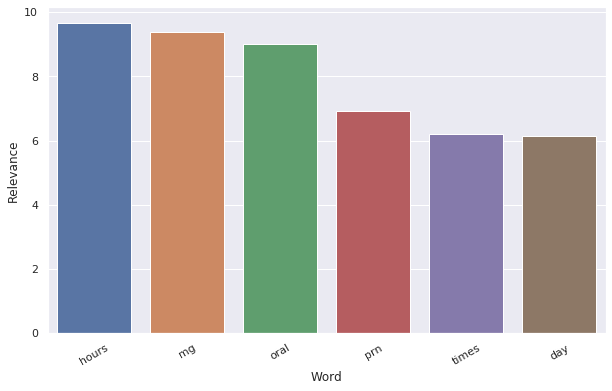

In [0]:
tr4w = TextRank4Keyword()
tr4w.analyze(all_documents_cleaned_joined, candidate_pos = pos, window_size=3, lower=True)
show_graph(tr4w.get_dataframe(number_of_figures))

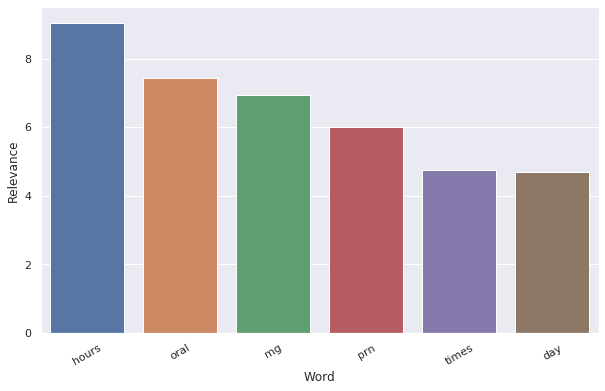

In [0]:
tr4w = TextRank4Keyword()
tr4w.analyze(early_stage_documents_cleaned_joined, candidate_pos = pos, window_size=3, lower=True)
show_graph(tr4w.get_dataframe(number_of_figures))

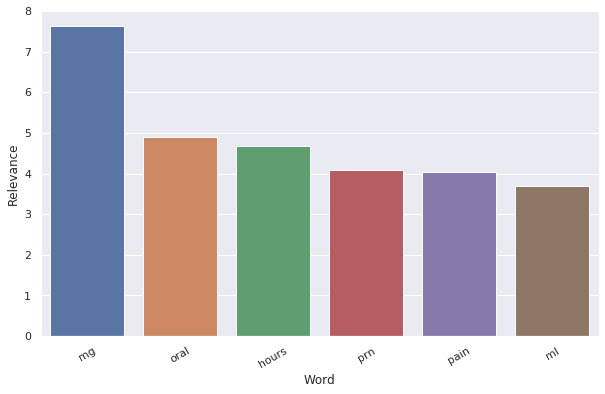

In [0]:
tr4w = TextRank4Keyword()
tr4w.analyze(later_stage_documents_cleaned_joined, candidate_pos = pos, window_size=3, lower=True)
show_graph(tr4w.get_dataframe(number_of_figures))

### PositionRank

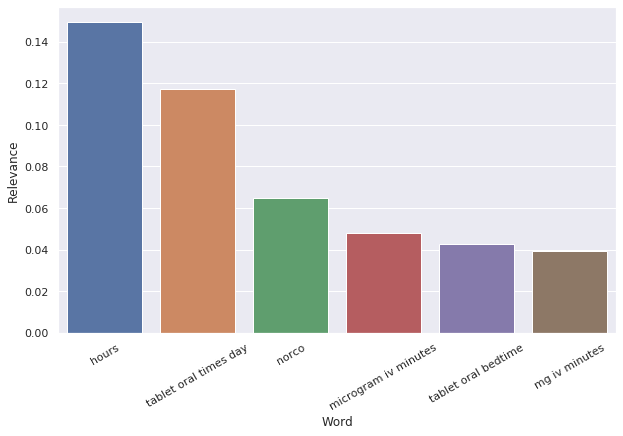

In [0]:
topicrank_df = pd.DataFrame(get_topicrank_keyphrases(all_documents_cleaned_joined, number_of_figures), columns=['Word', 'Relevance'])
show_graph(topicrank_df)

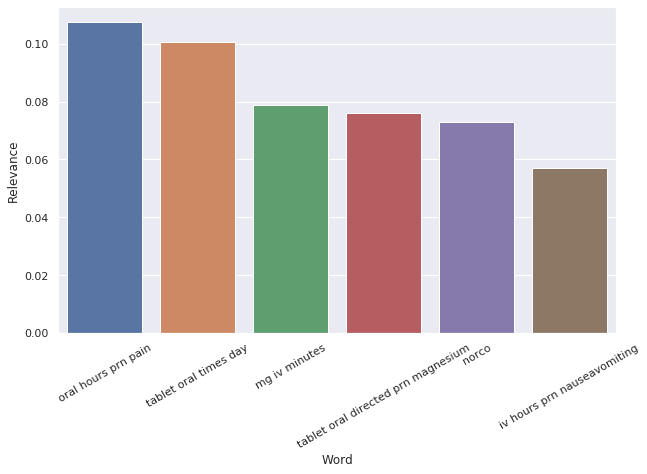

In [0]:
topicrank_df = pd.DataFrame(get_topicrank_keyphrases(early_stage_documents_cleaned_joined, number_of_figures), columns=['Word', 'Relevance'])
show_graph(topicrank_df)

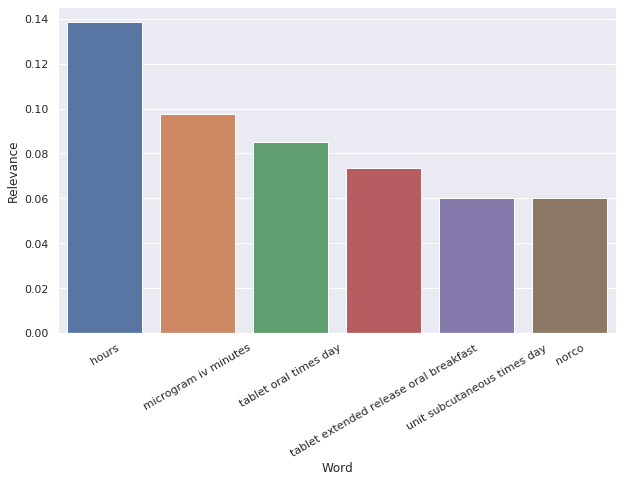

In [0]:
topicrank_df = pd.DataFrame(get_topicrank_keyphrases(later_stage_documents_cleaned_joined, number_of_figures), columns=['Word', 'Relevance'])
show_graph(topicrank_df)